In [3]:
from google.colab import drive
drive.mount('/content/drive')

import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio as rio
import rioxarray as rxr

# Update the directory path
directory_path = '/content/drive/MyDrive/MyProject'
# Function to process a single TIFF file and save it as a CSV
def process_tiff_to_csv(tif_path, csv_path, population_type):
    # Load the GeoTIFF data
    raw_data = rxr.open_rasterio(tif_path)
    lat = np.array(raw_data.y)
    lon = np.array(raw_data.x)

    # Get population values
    with rio.open(tif_path) as source:
        population_data = source.read(1)

    # Collect longitudes, latitudes, and population into a DataFrame
    population_data = population_data.flatten()
    lon_tiled = np.tile(lon, len(lat))
    lat_tiled = np.tile(np.array([lat]).T, len(lon)).flatten()
    df = pd.DataFrame({'longitude': lon_tiled, 'latitude': lat_tiled, population_type: population_data})

    # Keep spaces only if they have people
    df = df.loc[df[population_type] > 0].reset_index(drop=True)

    # Save the DataFrame as a CSV file
    df.to_csv(csv_path, index=False)

# Process KilifiPopDen1.tif and save it as KilifiPopDensity.csv
den_tif_path = '/content/drive/MyDrive/MyProject/KiambuPop.tif'
den_csv_path = '/content/drive/MyDrive/MyProject/KiambuPopD.csv'
process_tiff_to_csv(den_tif_path, den_csv_path, 'population_density')

display(pd.read_csv('/content/drive/MyDrive/MyProject/KiambuPopD.csv'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,longitude,latitude,population_density
0,36.670250,-0.757877,3.169761
1,36.669418,-0.758710,1.033295
2,36.670250,-0.758710,0.906634
3,36.667752,-0.759542,6.763562
4,36.668585,-0.759542,14.010201
...,...,...,...
111563,36.666087,-1.309091,26.368444
111564,36.666920,-1.309091,18.480326
111565,36.665254,-1.309924,2.014171
111566,36.666087,-1.309924,12.894526


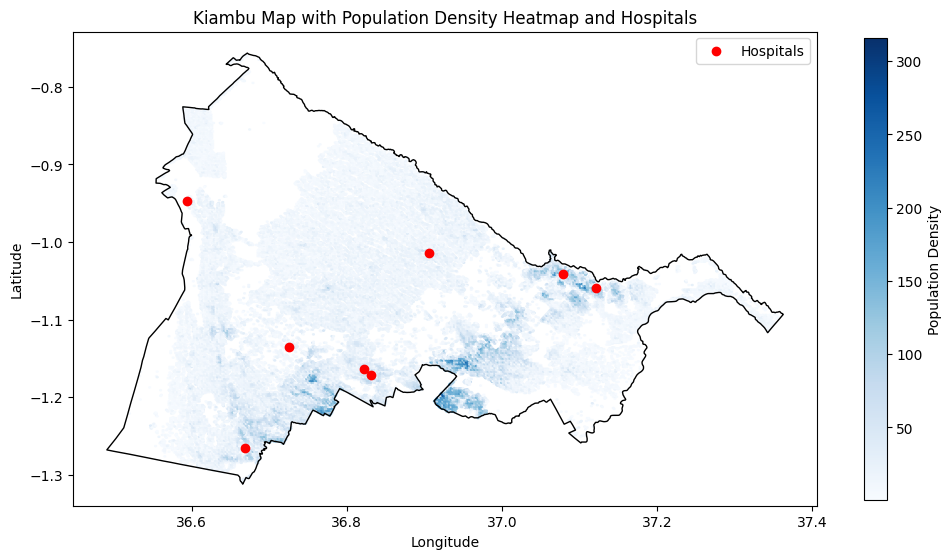

In [4]:
import matplotlib.pyplot as plt
# Define the full paths to your shapefiles and the updated population CSV on Google Drive
kiambu_shapefile = '/content/drive/MyDrive/MyProject/Kiambu.shp'
hospitals_csv = '/content/drive/MyDrive/MyProject/KiambuHospitals.csv'
population_csv = '/content/drive/MyDrive/MyProject/KiambuPopD.csv'

# Read the shapefiles
kiambu = gpd.read_file(kiambu_shapefile)

# Read the hospitals data from a CSV
hospitals = pd.read_csv(hospitals_csv)

# Read the updated population data
population_data = pd.read_csv(population_csv)

# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the Kiambu shapefile as a hollow outline with a black border
kiambu.boundary.plot(ax=ax, color='black', linewidth=1)

# Create a higher-resolution grid for the population heatmap
hb = ax.hexbin(population_data['longitude'], population_data['latitude'], gridsize=400, C=population_data['population_density'], cmap='Blues', mincnt=1)

# Create a colorbar for the heatmap
cb = plt.colorbar(hb, ax=ax, label='Population Density', shrink=0.5)

# Plot the hospitals that are open on weekends
ax.scatter(hospitals['Longitude'], hospitals['Latitude'], color='red', label='Hospitals', zorder=5)

# Add a legend
ax.legend()

# Set axis labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Set the title
ax.set_title('Kiambu Map with Population Density Heatmap and Hospitals')

# Show the map
plt.show()

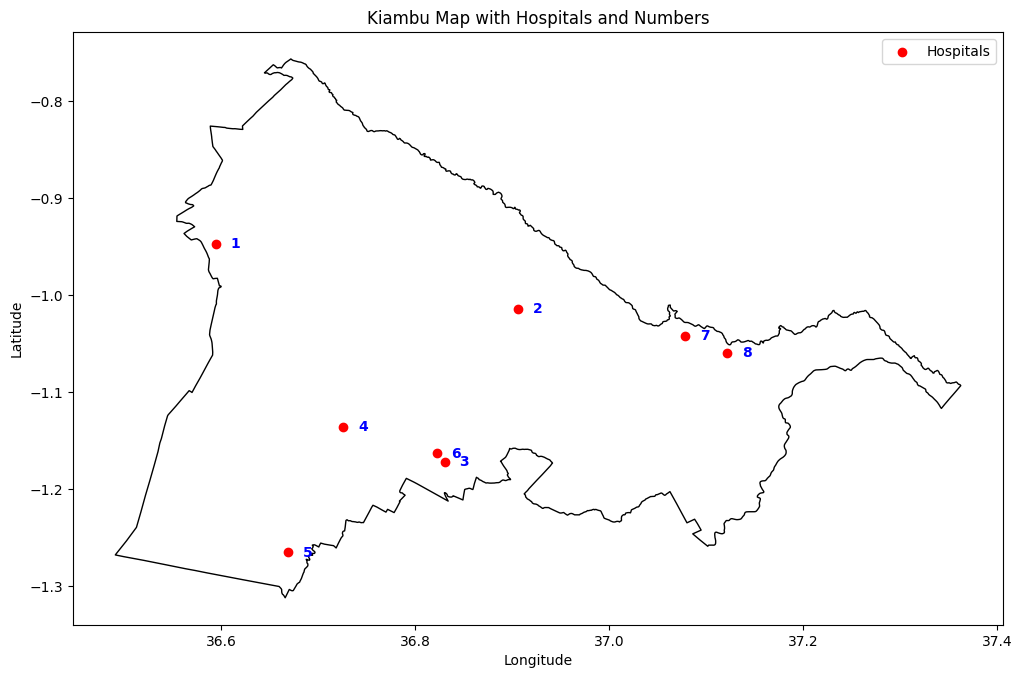

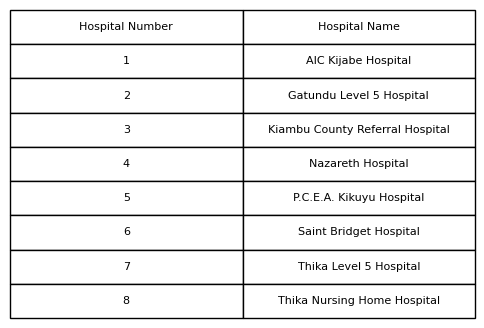

In [27]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the Kiambu shape
kiambu.boundary.plot(ax=ax, color='black', linewidth=1)

# Scatter plot for hospitals
scatter = ax.scatter(hospitals['Longitude'], hospitals['Latitude'], color='red', label='Hospitals', zorder=5)

# Add numbers to hospitals and create a separate table
hospital_numbers = []
hospital_names = []

for index, row in hospitals.iterrows():
    number = index + 1  # Assign numbers starting from 1
    hospital_numbers.append(number)
    hospital_names.append(row['Name'])
    ax.text(row['Longitude'] + 0.02, row['Latitude'], str(number), color='blue', fontsize=10, weight='bold', ha='center', va='center', zorder=10)

# Legend, axis labels, and title
ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Kiambu Map with Hospitals and Numbers')

# Ensure red points are on top of the numbers
ax.set_zorder(1)
ax.patch.set_zorder(0)

# Display the map
plt.show()

# Create a separate table outlining the names of the hospitals after displaying the map
hospital_table = pd.DataFrame({'Hospital Number': hospital_numbers, 'Hospital Name': hospital_names})

# Display the hospital table with borders
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')  # Turn off axis
table = ax.table(cellText=hospital_table.values, colLabels=hospital_table.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1], edges='LRBT')  # Combine edge codes into a single string
table.auto_set_font_size(False)
table.set_fontsize(8)
plt.show()